In [1]:
%matplotlib inline
import os, sys, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from sklearn.metrics import accuracy_score, confusion_matrix
import os
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 12

In [ ]:
!nvidia-smi

# Preprocess

In [3]:
X_scale = np.load("./dataset/train_dataset_10k.npz")['X']
y_scale = np.load("./dataset/train_dataset_10k.npz")['y']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y_scale, 
                                                    test_size=1-0.649, random_state=60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6490, 2600) (6490,)
(3510, 2600) (3510,)


# Training

In [4]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


## Set up cuda GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [6]:
"""convert numpy array to torch tensor running on CUDA GPU"""

X = torch.from_numpy(X_scale).float()
X = X.view(len(X), 1, -1).to(device)

Y = torch.from_numpy(y_scale).long()
Y = torch.autograd.Variable(Y).view(len(Y), 1, -1).to(device)


In [7]:
# Hyper-parameters
sequence_length = 2600
input_size = 2600
hidden_size = 128
num_layers = 3
num_classes = 3
batch_size = 64
num_epochs = 100
learning_rate = 0.01



model = RNN(input_size, hidden_size, num_layers, num_classes ,device).to(device)
print(model)

RNN(
  (lstm): LSTM(2600, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = 5000
for epoch in range(num_epochs):
    permutation = torch.randperm(X.size()[0])
    
    for i in range(0, X.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X[indices], Y[indices].squeeze()
        
        # Forward pass
        outputs = model(batch_x).to(device)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epochs, loss.item()))

Epoch [10/100], Loss: 0.0086
Epoch [20/100], Loss: 0.0089
Epoch [30/100], Loss: 0.0083
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0010
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0005


## Score

In [9]:
X_test = torch.from_numpy(X_test).float().view(len(X_test), 1, -1)

In [10]:
y_pred = model(X_test.to(device))

y_pred = np.array(torch.max(y_pred.cpu().data, 1).indices)

print("accuraccy = {:.3f}".format(accuracy_score(y_test, y_pred)))
print("confusion matrix is: \n{}".format(confusion_matrix(y_test, y_pred)))

accuraccy = 0.994
confusion matrix is: 
[[ 469    0    1]
 [   5  126    0]
 [  14    0 2895]]


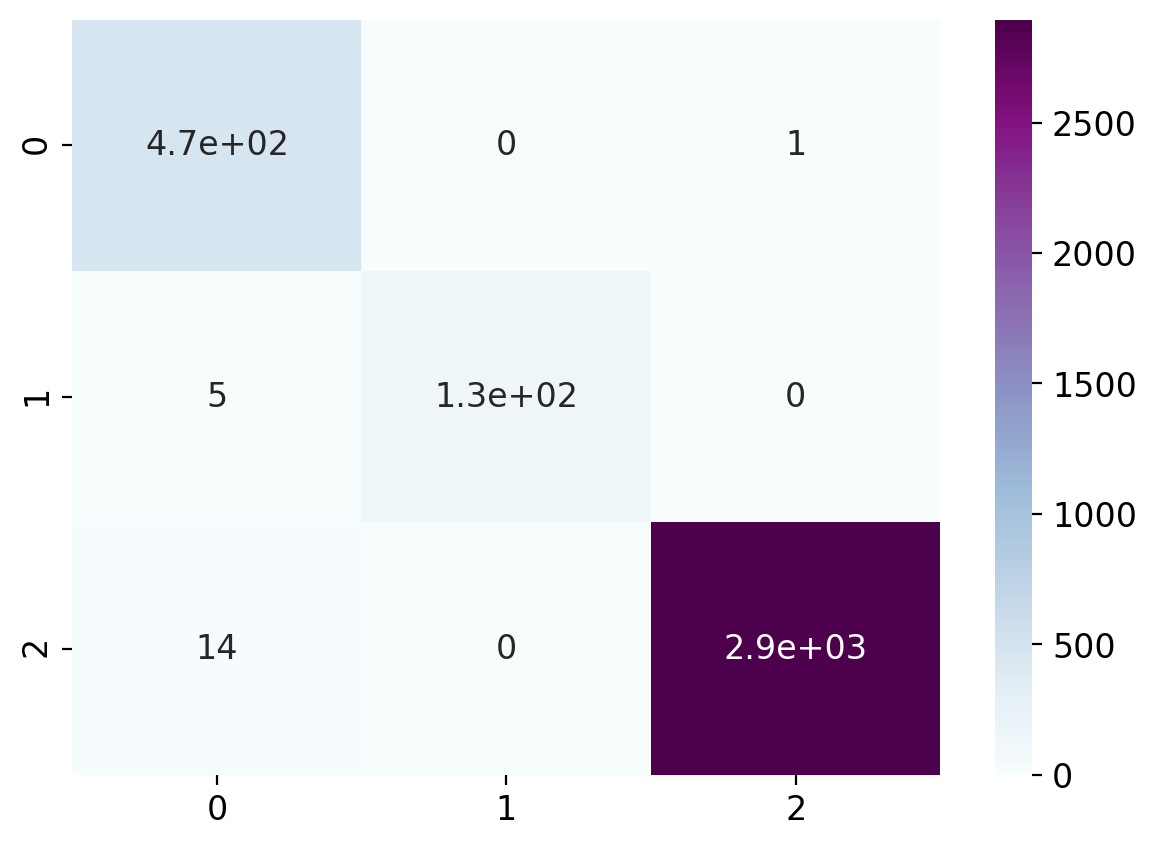

In [11]:
import seaborn as sns
import pylab as pl
pl.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, 
            cmap='BuPu');


In [ ]:
# torch.save(model, "./models/rnn.pt")